In [1]:
import os
import torch
from pytorch3d.io import load_obj, save_obj
from pytorch3d.structures import Meshes
from pytorch3d.utils import ico_sphere
from pytorch3d.ops import sample_points_from_meshes
from pytorch3d.loss import (
    chamfer_distance, 
    mesh_edge_loss, 
    mesh_laplacian_smoothing, 
    mesh_normal_consistency,
)
import numpy as np
from tqdm import tqdm_notebook
%matplotlib notebook 
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 80
mpl.rcParams['figure.dpi'] = 80

# Set the device
device = torch.device("cpu")
from graphein.construct_meshes import ProteinMesh

In [2]:
p = ProteinMesh()
verts, faces, _ = p.create_mesh(pdb_code='3eiy', out_dir='../examples/meshes/')

faces_idx = faces.verts_idx.to(device)
verts = verts.to(device)

# We scale normalize and center the target mesh to fit in a sphere of radius 1 centered at (0,0,0). 
# (scale, center) will be used to bring the predicted mesh to its original center and scale
# Note that normalizing the target mesh, speeds up the optimization but is not necessary!
center = verts.mean(0)
verts = verts - center
scale = max(verts.abs().max(0)[0])
verts = verts / scale

trg_mesh = Meshes(verts=[verts], faces=[faces_idx])

None
Saved file to: ../examples/meshes/3eiy.obj


/Users/arianjamasb/opt/anaconda3/envs/graphein/lib/python3.7/site-packages/pytorch3d/io/obj_io.py:70: UserWarning: Faces have invalid indices
  warnings.warn("Faces have invalid indices")


In [3]:
# We initialize the source shape to be a sphere of radius 1
src_mesh = ico_sphere(4, device)

/Users/distiller/project/conda/conda-bld/pytorch_1587428061935/work/aten/src/ATen/native/BinaryOps.cpp:81: UserWarning: Integer division of tensors using div or / is deprecated, and in a future release div will perform true division as in Python 3. Use true_divide or floor_divide (// in Python) instead.


In [4]:
def plot_pointcloud(mesh, title, itername):
    # Sample points uniformly from the surface of the mesh.
    points = sample_points_from_meshes(mesh, 5000)
    x, y, z = points.clone().detach().cpu().squeeze().unbind(1)    
    fig = plt.figure(figsize=(5, 5))
    ax = Axes3D(fig)
    ax.scatter3D(x, z, -y)
    ax.set_xlabel('x')
    ax.set_ylabel('z')
    ax.set_zlabel('y')
    ax.set_title(title)
    ax.view_init(190, 30)
    if itername:
        plt.savefig(str(itername)+'.png')
    plt.show()

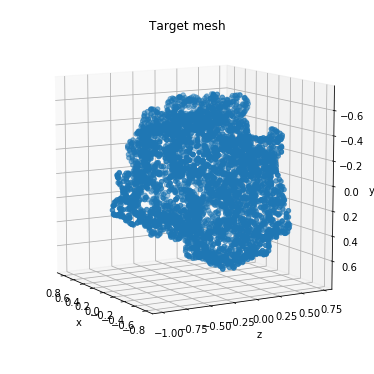

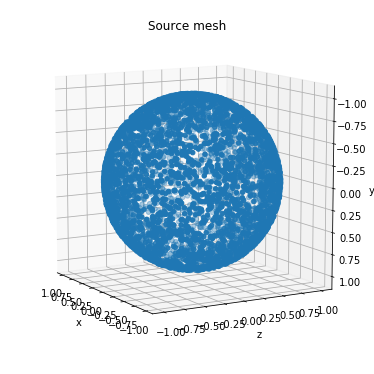

In [11]:
%matplotlib inline
plot_pointcloud(trg_mesh, "Target mesh", itername=False)
plot_pointcloud(src_mesh, "Source mesh", itername='start')

In [6]:
# We will learn to deform the source mesh by offsetting its vertices
# The shape of the deform parameters is equal to the total number of vertices in src_mesh
deform_verts = torch.full(src_mesh.verts_packed().shape, 0.0, device=device, requires_grad=True)

In [7]:
# The optimizer
optimizer = torch.optim.SGD([deform_verts], lr=1.0, momentum=0.9)

/Users/arianjamasb/opt/anaconda3/envs/graphein/lib/python3.7/site-packages/ipykernel_launcher.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  del sys.path[0]


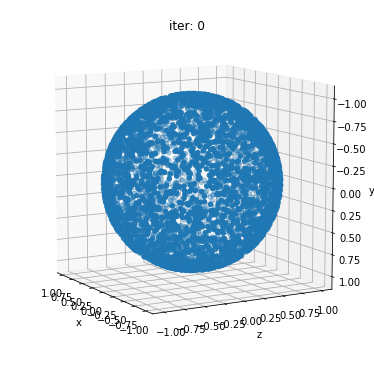

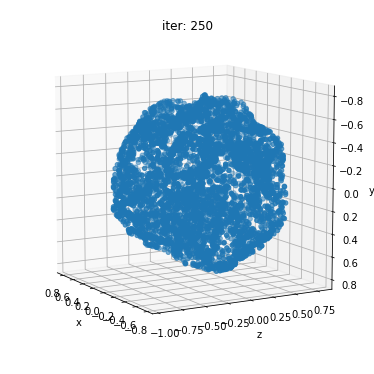

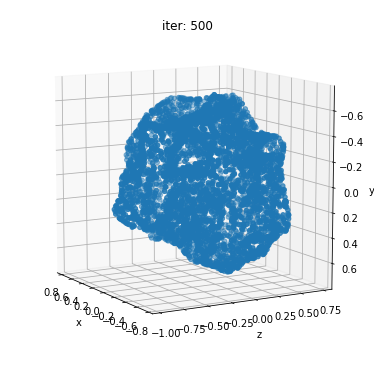

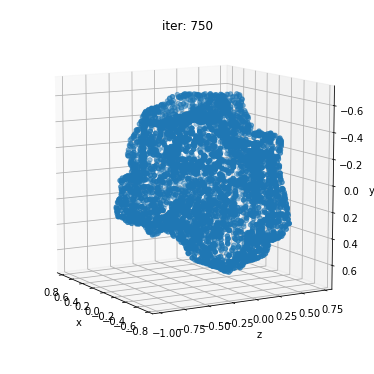

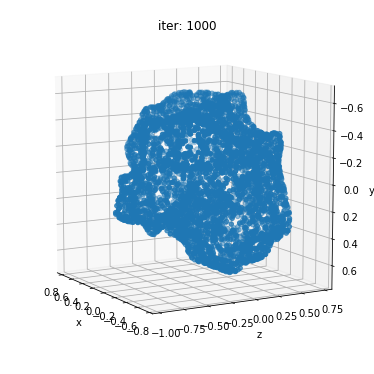

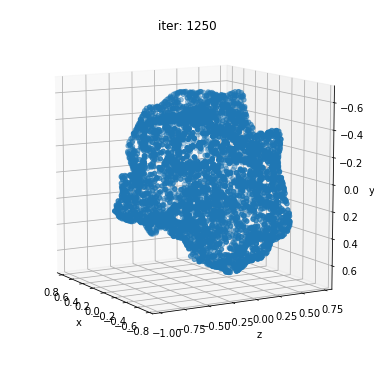

In [8]:
# Number of optimization steps
Niter = 1500
# Weight for the chamfer loss
w_chamfer = 1.0 
# Weight for mesh edge loss
w_edge = 1.0 
# Weight for mesh normal consistency
w_normal = 0.01 
# Weight for mesh laplacian smoothing
w_laplacian = 0.1 
# Plot period for the losses
plot_period = 250
loop = tqdm_notebook(range(Niter))

chamfer_losses = []
laplacian_losses = []
edge_losses = []
normal_losses = []

%matplotlib inline

for i in loop:
    # Initialize optimizer
    optimizer.zero_grad()
    
    # Deform the mesh
    new_src_mesh = src_mesh.offset_verts(deform_verts)
    
    # We sample 5k points from the surface of each mesh 
    sample_trg = sample_points_from_meshes(trg_mesh, 5000)
    sample_src = sample_points_from_meshes(new_src_mesh, 5000)
    
    # We compare the two sets of pointclouds by computing (a) the chamfer loss
    loss_chamfer, _ = chamfer_distance(sample_trg, sample_src)
    
    # and (b) the edge length of the predicted mesh
    loss_edge = mesh_edge_loss(new_src_mesh)
    
    # mesh normal consistency
    loss_normal = mesh_normal_consistency(new_src_mesh)
    
    # mesh laplacian smoothing
    loss_laplacian = mesh_laplacian_smoothing(new_src_mesh, method="uniform")
    
    # Weighted sum of the losses
    loss = loss_chamfer * w_chamfer + loss_edge * w_edge + loss_normal * w_normal + loss_laplacian * w_laplacian
    
    # Print the losses
    loop.set_description('total_loss = %.6f' % loss)
    
    # Save the losses for plotting
    chamfer_losses.append(loss_chamfer)
    edge_losses.append(loss_edge)
    normal_losses.append(loss_normal)
    laplacian_losses.append(loss_laplacian)
    
    # Plot mesh
    if i % plot_period == 0:
        plot_pointcloud(new_src_mesh, title="iter: %d" % i, itername=i)
        
    # Optimization step
    loss.backward()
    optimizer.step()